In [1]:
#Setup and cleaning the Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")
sns.set(font_scale=1.1)

# Load data
df = pd.read_csv("openfoodfacts_nutrition_final_2025-12-10.csv")

# Basic cleaning
df['nutriscore_grade'] = df['nutriscore_grade'].astype(str).str.lower().replace({'nan': np.nan})
df['ecoscore_grade'] = df['ecoscore_grade'].astype(str).str.lower().replace({'nan': np.nan})
df['nova_group'] = pd.to_numeric(df['nova_group'], errors='coerce')

for col in ['energy-kcal_100g','fat_100g','saturated-fat_100g','carbohydrates_100g',
            'sugars_100g','fiber_100g','proteins_100g','salt_100g','sodium_100g']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Helper: first country / first category for simpler grouping
df['main_country'] = df['countries'].astype(str).str.split(',').str[0].str.strip()
df['main_category'] = df['categories'].astype(str).str.split(',').str[0].str.strip()

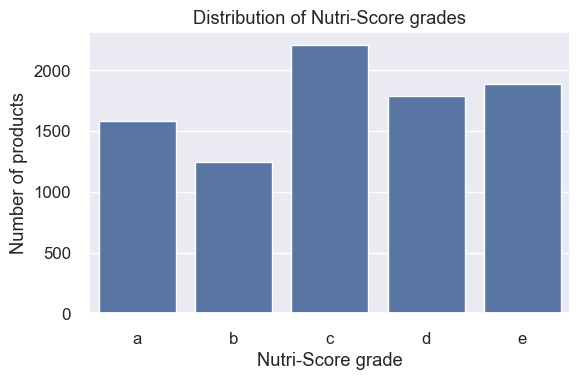

In [2]:
#1. Distribution of Nutri‑Score grades (bar)
#Question: How are food products distributed across Nutri-Score grades (A-E) globally?
order_nutri = ['a','b','c','d','e']
plt.figure(figsize=(6,4))
sns.countplot(
    data=df[df['nutriscore_grade'].isin(order_nutri)],
    x='nutriscore_grade',
    order=order_nutri
)
plt.xlabel("Nutri-Score grade")
plt.ylabel("Number of products")
plt.title("Distribution of Nutri-Score grades")
plt.tight_layout()
plt.show()


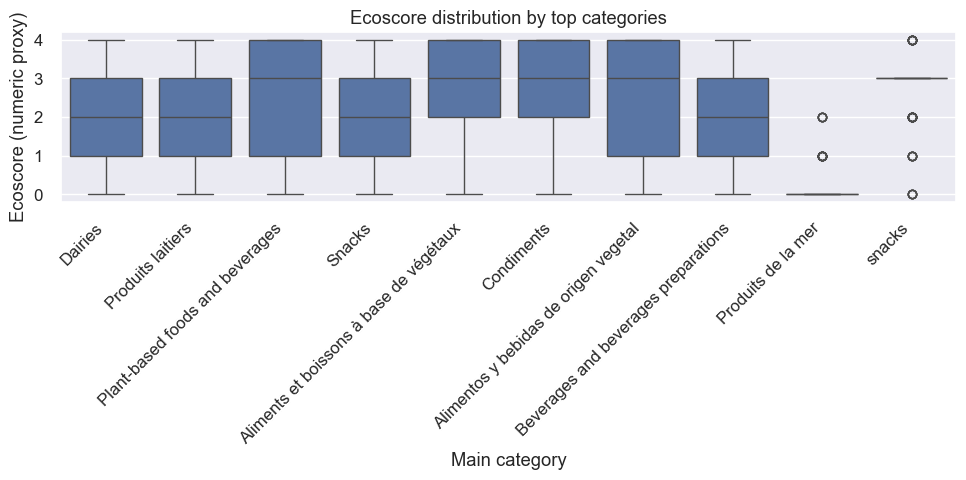

In [3]:
#2. Ecoscore distribution by product category
#Question: How does Ecoscore vary across main food categories (Plant-based foods, Dairies, Snacks, etc.)?
# Map ecoscore letters to numeric (rough proxy)
eco_map = {'a':4,'b':3,'c':2,'d':1,'e':0}
df['ecoscore_num'] = df['ecoscore_grade'].map(eco_map)

# Focus on categories that have ecoscore
cat_counts = df[~df['ecoscore_num'].isna()]['main_category'].value_counts()
top_cats = cat_counts.head(10).index

plt.figure(figsize=(10,5))
sns.boxplot(
    data=df[(df['main_category'].isin(top_cats)) & (~df['ecoscore_num'].isna())],
    x='main_category',
    y='ecoscore_num'
)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Main category")
plt.ylabel("Ecoscore (numeric proxy)")
plt.title("Ecoscore distribution by top categories")
plt.tight_layout()
plt.show()


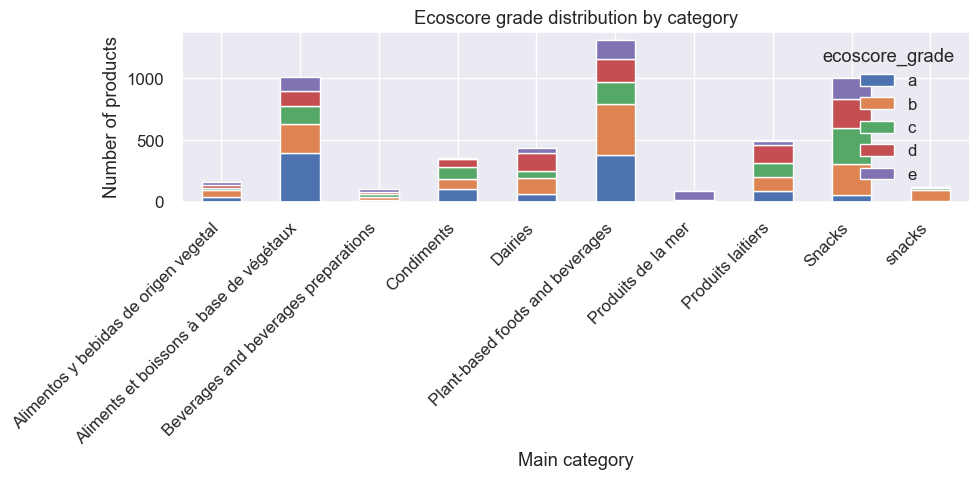

In [4]:
eco_valid = df[df['ecoscore_grade'].isin(list(eco_map.keys()))]
top_cats = eco_valid['main_category'].value_counts().head(10).index

cross = (eco_valid[eco_valid['main_category'].isin(top_cats)]
         .pivot_table(index='main_category',
                      columns='ecoscore_grade',
                      values='code',
                      aggfunc='count',
                      fill_value=0))

cross = cross[sorted(cross.columns)]   # order a–e

cross.plot(kind='bar', stacked=True, figsize=(10,5))
plt.ylabel("Number of products")
plt.xlabel("Main category")
plt.title("Ecoscore grade distribution by category")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


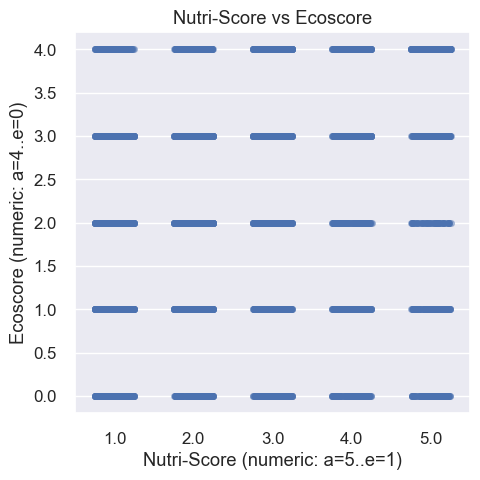

Pearson corr: 0.2528103062518217


In [5]:
#3. Correlation between Nutri‑Score and Ecoscore (scatter)
#Question: Is there a relationship between nutritional quality (Nutri-Score) and environmental impact (Ecoscore)?
nutri_map = {'a':5,'b':4,'c':3,'d':2,'e':1}
df['nutriscore_num'] = df['nutriscore_grade'].map(nutri_map)

corr_df = df.dropna(subset=['nutriscore_num', 'ecoscore_num'])

plt.figure(figsize=(5,5))
sns.stripplot(
    data=corr_df,
    x='nutriscore_num',
    y='ecoscore_num',
    jitter=0.25,
    alpha=0.5
)
plt.xlabel("Nutri-Score (numeric: a=5..e=1)")
plt.ylabel("Ecoscore (numeric: a=4..e=0)")
plt.title("Nutri-Score vs Ecoscore")
plt.tight_layout()
plt.show()

print("Pearson corr:", corr_df['nutriscore_num'].corr(corr_df['ecoscore_num']))


In [6]:
#4. Ultra‑processed vs unprocessed foods by country (choropleth‑ready)
#Question: Which countries have the highest share of ultra-processed (NOVA 4) vs unprocessed (NOVA 1) foods?
# Define processing level
def nova_level(n):
    if pd.isna(n):
        return np.nan
    if n <= 1.5:
        return "unprocessed/minimally"
    if n >= 3.5:
        return "ultra-processed"
    return "other"

df['processing_level'] = df['nova_group'].apply(nova_level)

country_proc = (df[df['processing_level'].isin(['unprocessed/minimally','ultra-processed'])]
                .groupby(['main_country', 'processing_level'])['code']
                .count()
                .unstack(fill_value=0))

country_proc['total'] = country_proc.sum(axis=1)
country_proc['ultra_share'] = country_proc['ultra-processed'] / country_proc['total']

print(country_proc.head())


processing_level  ultra-processed  unprocessed/minimally  total  ultra_share
main_country                                                                
Albania                         1                      0      1          1.0
Albanie                         1                      0      1          1.0
Albanien                        1                      0      1          1.0
Albanija                        1                      0      1          1.0
Albânia                         1                      0      1          1.0


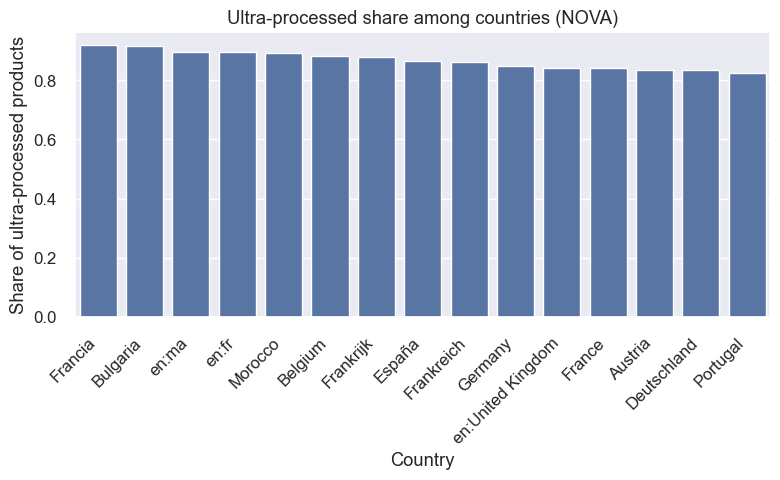

In [7]:
top_country = (country_proc[country_proc['total'] >= 30]
               .sort_values('ultra_share', ascending=False)
               .head(15))

plt.figure(figsize=(8,5))
sns.barplot(
    data=top_country.reset_index(),
    x='main_country',
    y='ultra_share'
)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Share of ultra-processed products")
plt.xlabel("Country")
plt.title("Ultra-processed share among countries (NOVA)")
plt.tight_layout()
plt.show()


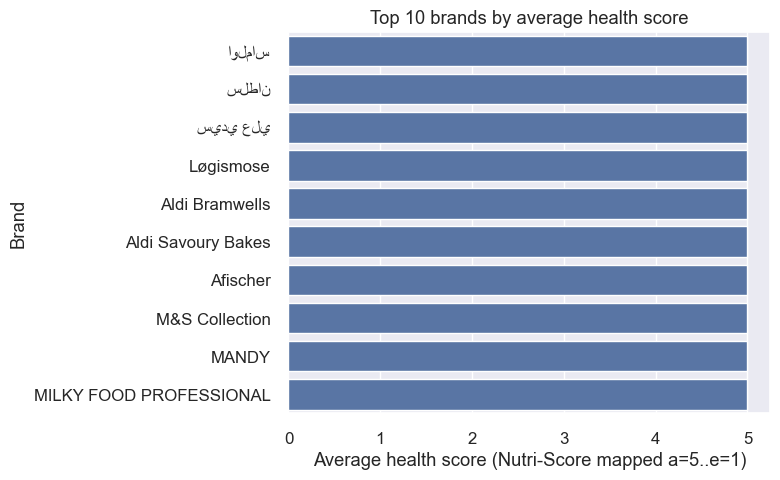

In [8]:
#5. Top 10 brands by average health score (using Nutri‑Score)
#Question: Which 10 brands have the highest average Nutri-Score across their products?
df['health_score'] = df['nutriscore_num']  # higher is better

brand_health = (df.dropna(subset=['health_score'])
                  .groupby('brands')['health_score']
                  .mean()
                  .sort_values(ascending=False))

top_brands = brand_health[brand_health.index.notna()].head(10)

plt.figure(figsize=(8,5))
sns.barplot(
    x=top_brands.values,
    y=top_brands.index
)
plt.xlabel("Average health score (Nutri-Score mapped a=5..e=1)")
plt.ylabel("Brand")
plt.title("Top 10 brands by average health score")
plt.tight_layout()
plt.show()

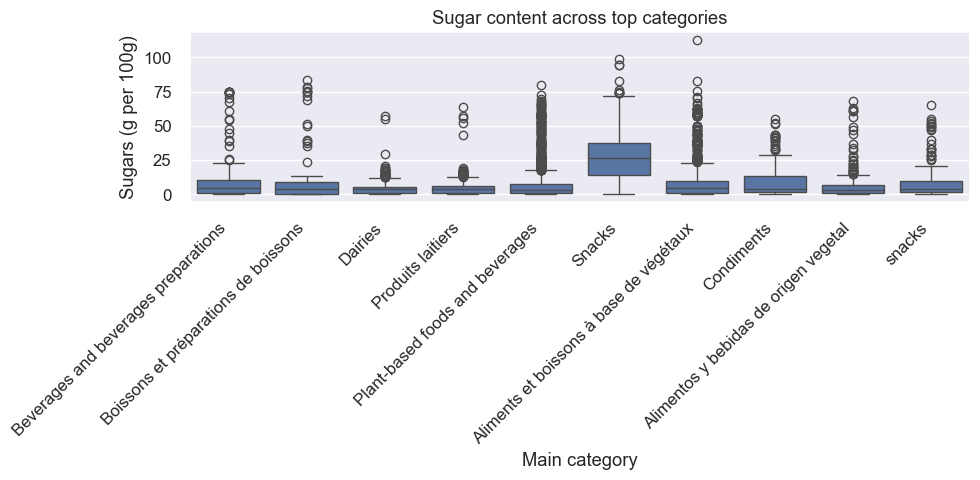

In [9]:
#6. Sugar content comparison across categories (box plot)
#Question: How does sugar content (g/100g) vary across major food categories?
sugar_df = df.dropna(subset=['sugars_100g'])
cat_counts = sugar_df['main_category'].value_counts()
top_cats = cat_counts.head(10).index

plt.figure(figsize=(10,5))
sns.boxplot(
    data=sugar_df[sugar_df['main_category'].isin(top_cats)],
    x='main_category',
    y='sugars_100g'
)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Sugars (g per 100g)")
plt.xlabel("Main category")
plt.title("Sugar content across top categories")
plt.tight_layout()
plt.show()


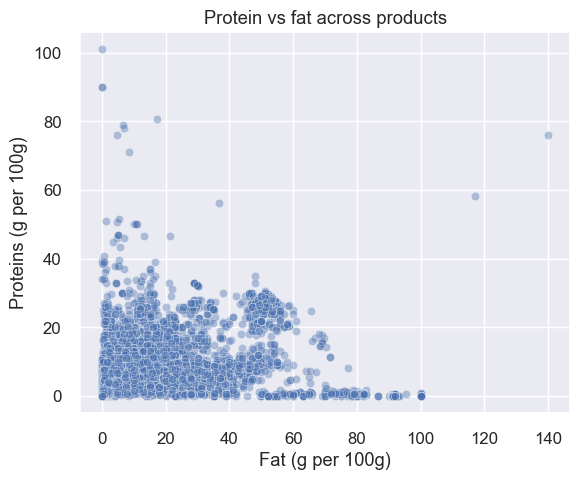

In [10]:
#7. Protein vs fat across products (scatter)
#Question: What is the relationship between protein and fat content across all products?
pf_df = df.dropna(subset=['proteins_100g', 'fat_100g'])

plt.figure(figsize=(6,5))
sns.scatterplot(
    data=pf_df,
    x='fat_100g',
    y='proteins_100g',
    alpha=0.4
)
plt.xlabel("Fat (g per 100g)")
plt.ylabel("Proteins (g per 100g)")
plt.title("Protein vs fat across products")
plt.tight_layout()
plt.show()


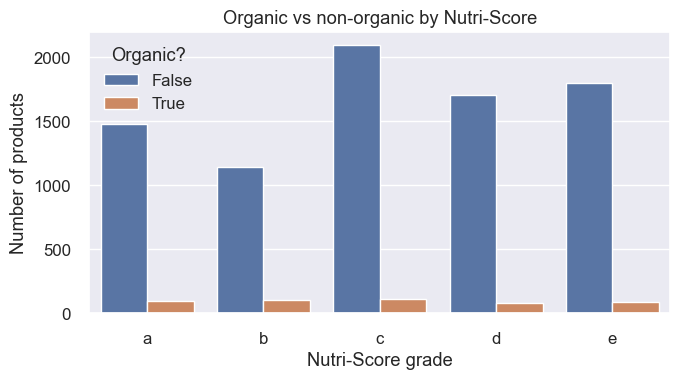

In [11]:
#8. “Organic” labels vs Nutri‑Score
#Question: Do "Organic" labeled products have better Nutri-Scores than non-organic?
df['is_organic'] = df['labels'].astype(str).str.lower().str.contains('organic')

organic_nutri = df[df['nutriscore_grade'].isin(order_nutri)]

plt.figure(figsize=(7,4))
sns.countplot(
    data=organic_nutri,
    x='nutriscore_grade',
    hue='is_organic',
    order=order_nutri
)
plt.xlabel("Nutri-Score grade")
plt.ylabel("Number of products")
plt.title("Organic vs non-organic by Nutri-Score")
plt.legend(title="Organic?")
plt.tight_layout()
plt.show()

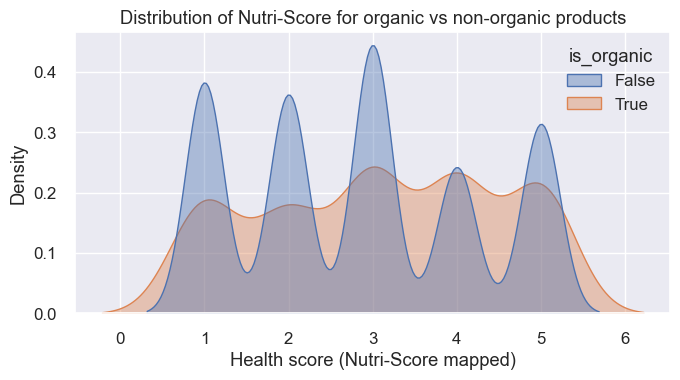

In [12]:
plt.figure(figsize=(7,4))
sns.kdeplot(
    data=organic_nutri.dropna(subset=['health_score']),
    x='health_score',
    hue='is_organic',
    common_norm=False,
    fill=True,
    alpha=0.4
)
plt.xlabel("Health score (Nutri-Score mapped)")
plt.title("Distribution of Nutri-Score for organic vs non-organic products")
plt.tight_layout()
plt.show()

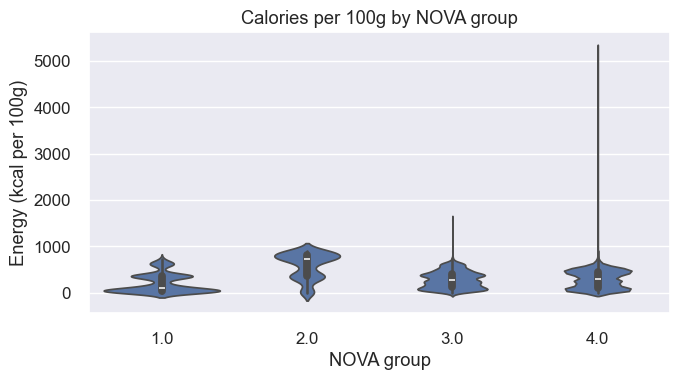

In [13]:
#9. Calories per 100g for different NOVA groups (violin)
#Question: How do calorie densities (kcal/100g) differ between NOVA processing levels (1-4)?
cal_df = df.dropna(subset=['energy-kcal_100g', 'nova_group'])
cal_df = cal_df[cal_df['nova_group'].between(1,4)]

plt.figure(figsize=(7,4))
sns.violinplot(
    data=cal_df,
    x='nova_group',
    y='energy-kcal_100g',
    inner='box'
)
plt.xlabel("NOVA group")
plt.ylabel("Energy (kcal per 100g)")
plt.title("Calories per 100g by NOVA group")
plt.tight_layout()
plt.show()

              high_sugar_share  n_products
main_country                              
Albania                    1.0           1
Albanie                    0.0           1
Albanien                   0.0           1
Albanija                   0.0           1
Albânia                    0.0           1


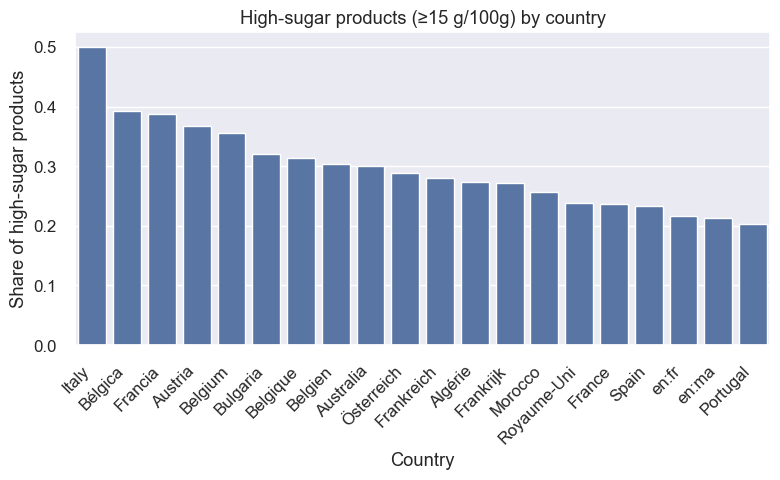

In [14]:
#10. Country‑wise prevalence of high‑sugar products
#Question: Which countries have the highest percentage of products with ≥15g sugar/100g?
threshold = 15  # g per 100g
df['high_sugar'] = df['sugars_100g'] >= threshold

country_sugar = (df.dropna(subset=['high_sugar'])
                 .groupby('main_country')['high_sugar']
                 .agg(['mean','count'])
                 .rename(columns={'mean':'high_sugar_share','count':'n_products'}))

print(country_sugar.head())

# Heatmap-like bar for countries with enough products
plot_df = country_sugar[country_sugar['n_products'] >= 30].sort_values('high_sugar_share', ascending=False).head(20)

plt.figure(figsize=(8,5))
sns.barplot(
    data=plot_df.reset_index(),
    x='main_country',
    y='high_sugar_share'
)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Country")
plt.ylabel("Share of high-sugar products")
plt.title(f"High-sugar products (≥{threshold} g/100g) by country")
plt.tight_layout()
plt.show()

In [15]:
#11. Most common allergens or additives by category (NLP‑style)
#Question: What are the most frequent allergens/ingredients mentioned in each category?
import re
from collections import Counter

ing = df[['main_category', 'ingredients_text']].dropna(subset=['ingredients_text'])

def simple_tokenize(text):
    text = str(text).lower()
    text = re.sub(r'[\n\r,;:\(\)\[\]\{\}]', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9_\- ]', ' ', text)
    tokens = [t.strip() for t in text.split() if len(t.strip()) > 2]
    return tokens

# Example: top additives/allergens for a given category
target_cat = 'Snacks'  # change as needed
sub = ing[ing['main_category'].str.contains(target_cat, case=False, na=False)]

counter = Counter()
for txt in sub['ingredients_text']:
    counter.update(simple_tokenize(txt))

most_common = counter.most_common(30)
print(most_common)

[('cacao', 1032), ('sucre', 907), ('poudre', 884), ('farine', 789), ('lait', 690), ('sodium', 575), ('sugar', 561), ('milk', 553), ('cocoa', 545), ('sel', 531), ('beurre', 517), ('powder', 494), ('soja', 464), ('flour', 449), ('salt', 439), ('carbonates', 422), ('huile', 415), ('oil', 378), ('mulsifiant', 375), ('wheat', 340), ('lever', 333), ('acide', 301), ('naturel', 290), ('butter', 281), ('ammonium', 277), ('sirop', 272), ('cithines', 271), ('colza', 263), ('syrup', 240), ('palm', 238)]


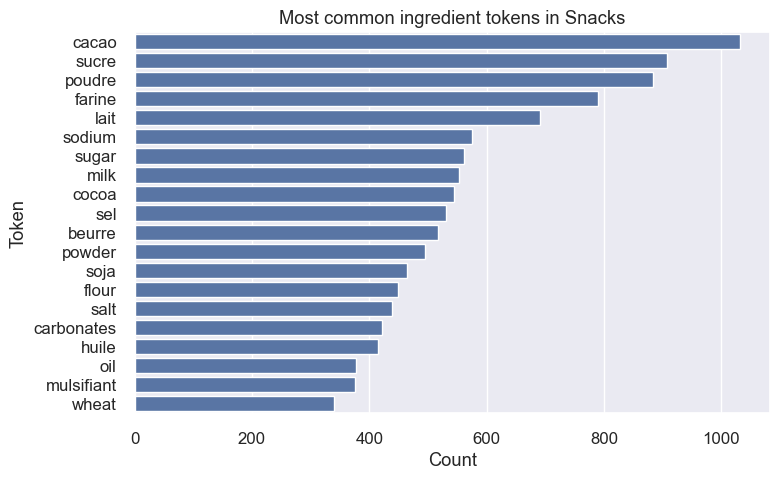

In [16]:
tokens, counts = zip(*most_common[:20])
plt.figure(figsize=(8,5))
sns.barplot(x=list(counts), y=list(tokens))
plt.xlabel("Count")
plt.ylabel("Token")
plt.title(f"Most common ingredient tokens in {target_cat}")
plt.tight_layout()
plt.show()

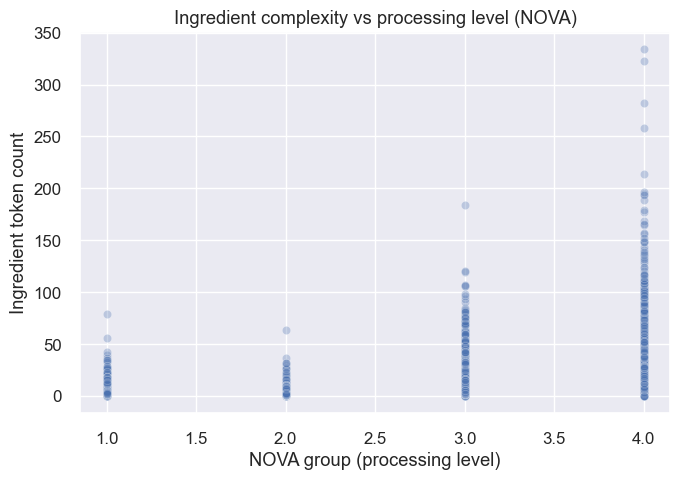

In [17]:
#12. Ingredient complexity vs processing level (scatter)
#Question: Do ultra-processed foods have more complex ingredient lists than minimally processed ones?
df['ingredient_count'] = df['ingredients_text'].astype(str).apply(
    lambda x: len(simple_tokenize(x)) if pd.notna(x) else np.nan
)

complex_df = df.dropna(subset=['ingredient_count', 'nova_group'])

plt.figure(figsize=(7,5))
sns.scatterplot(
    data=complex_df,
    x='nova_group',
    y='ingredient_count',
    alpha=0.3
)
plt.xlabel("NOVA group (processing level)")
plt.ylabel("Ingredient token count")
plt.title("Ingredient complexity vs processing level (NOVA)")
plt.tight_layout()
plt.show()